In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Set the directory containing the image files
data_dir = '/Users/kysgattu/Downloads/COVID-19_Radiography_Dataset2'

# Initialize empty lists to hold file paths and their corresponding labels
filepaths = []
labels = []

# Loop through all folders in the directory
for fold in os.listdir(data_dir):
    foldpath = os.path.join(data_dir, fold)

    # If a folder has a file extension, it's not a directory and is ignored
    if pathlib.Path(foldpath).suffix != '':
        continue

    # If the folder is a directory
    if os.path.isdir(foldpath):
        # Loop through all files in the directory
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            if os.path.isdir(fpath):
                # check if there are another folders
                if pathlib.Path(foldpath).suffix == '':
                    # check unneeded masks
                    if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                        continue

                    else:
                        o_file = os.listdir(fpath)
                        for f in o_file:
                            ipath = os.path.join(fpath, f)
                            filepaths.append(ipath)
                            labels.append(fold)

                else:
                    filepaths.append(fpath)
                    labels.append(fold)

# Convert the file paths and labels lists into a Pandas DataFrame for easier manipulation
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split the DataFrame into training, validation, and test sets
strat = df['labels']
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, train_size=0.66, shuffle=True, random_state=123, stratify=strat)
# Print the sizes of the resulting train, validation, and test sets
print(f'Train size: {len(train_df)}, Validation size: {len(valid_df)}, Test size: {len(test_df)}')


Train size: 16932, Validation size: 2793, Test size: 1440


In [3]:
# Calculate the length of the test dataset
ts_length = len(test_df)

# Find all factors of the test dataset length less than or equal to 80
factors = [n for n in range(1, ts_length+1) if ts_length % n == 0 and ts_length/n <= 80]

# Sort the factors in descending order and select the largest one as the batch size
test_batch_size = max(sorted(factors, reverse=True))

# Calculate the number of steps per epoch for the test dataset
test_steps = ts_length // test_batch_size

# Define a function that returns the input image unchanged
def scalar(img):
    return img

# Set up image data generators for the training, validation, and test datasets
tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  # Don't shuffle the test data
    batch_size=test_batch_size
)


Found 16932 validated image filenames belonging to 4 classes.
Found 2793 validated image filenames belonging to 4 classes.
Found 1440 validated image filenames belonging to 4 classes.


In [4]:
data_dict = train_gen.class_indices        # defines dictionary {'class': index}
classes = list(data_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)        # get a batch size samples from the generator

In [5]:
# calculate number of displayed samples
length = len(labels)        # length of batch size

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()


In [6]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


# Load pre-trained VGG19 model without top layer and freeze all layers
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg19.layers:
    layer.trainable = False

# Add custom top layer
x = Flatten()(vgg19.output)
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)



Metal device set to: Apple M1 Pro


2023-04-17 18:06:20.440836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-17 18:06:20.440999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Create new model with custom top layer
model = Model(inputs=vgg19.input, outputs=x)

# Compile model with categorical crossentropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [10]:
# Train the model for 10 epochs
history = model.fit(train_gen, validation_data=valid_gen, epochs=2, callbacks = early_stop)




Epoch 1/2
1059/1059 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8764

2023-04-17 18:15:02.731970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1059/1059 [==============================] - 468s 442ms/step - loss: 0.3854 - accuracy: 0.8764 - val_loss: 0.3720 - val_accuracy: 0.8568
Epoch 2/2
1059/1059 [==============================] - 474s 448ms/step - loss: 0.2605 - accuracy: 0.9064 - val_loss: 0.2683 - val_accuracy: 0.9083


In [12]:
model.save('VGG.h5')

In [24]:
model = keras.models.load_model('VGG.h5')

In [25]:
model.evaluate(test_gen)

2023-04-17 18:26:24.962929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 53s 2s/step - loss: 0.2290 - accuracy: 0.9202


[0.22901228070259094, 0.9201700687408447]

In [26]:
preds = model.predict_generator(test_gen)

2023-04-17 18:27:18.093677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [27]:
y_pred = np.argmax(preds, axis=1)

In [28]:
y_pred

array([1, 1, 1, ..., 2, 2, 2])

In [29]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)


In [30]:
cr = classification_report(test_gen.classes, y_pred)

In [31]:
classes

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [32]:
cm

array([[333,  10,  19,   0],
       [ 10, 520,  72,   0],
       [  6,  42, 964,   7],
       [  0,   0,   3, 131]])

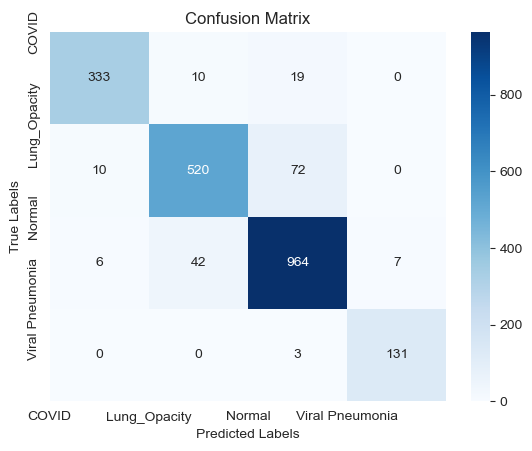

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true and y_pred are the true and predicted labels, respectively


# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1, 2, 3], labels=classes)
plt.yticks(ticks=[0, 1, 2, 3], labels=classes)
plt.show()


In [34]:
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       362
           1       0.91      0.86      0.89       602
           2       0.91      0.95      0.93      1019
           3       0.95      0.98      0.96       134

    accuracy                           0.92      2117
   macro avg       0.93      0.93      0.93      2117
weighted avg       0.92      0.92      0.92      2117

